# Monopoly and Markov Chains


The goal of this project is to use Markov chains to model the game of Monopoly. We aim to answer some simple questions about the game:
- What are the locations visited the most often? 
- After how many turns is the game at an equilibrium?
- Is there a better strategy? Should one alway build hotels? Can we stick to houses?

To ease the analysis we will simplify some of the rules by simplifying the rules to get out of jail, and neglect the effect of the "Chance" and the "Community chest" cards. We will also consider players that always stick to the same strategy.

Most of the following analysis were motivated by two articles from Ian stewarts in the Scientific American, (reproductions from the articles are linked [here](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Monopoly.html) or available on the course page).



## Summary of the game

Those short explanations of the game are taken from [this website](http://www.durangobill.com/Monopoly.html). You can as well check the rules on the wikipedia page ([english](https://en.wikipedia.org/wiki/Monopoly_(game)), [german](https://de.wikipedia.org/wiki/Monopoly)). 

### Rules of the game

#### Dice Rolls: 

 - A player rolls **a pair of dice** and moves his board piece (token) clockwise around the board. The number of board spaces he moves is equal to the sum of the dice. 
 - If he stops on a "Chance" or "Community Chest" board space, he picks up a card from the indicated stack, and if instructed, moves his token to a new location. 
 - If he had doubles, he repeats this process. 
 - However, if he has three doubles in a row, he instead goes directly to Jail.

![monopoly-classique-plateau.jpg](attachment:monopoly-classique-plateau.jpg)



#### Going to Jail: 

If a player is instructed to go to Jail (at any point during his turn), his turn ends regardless of the doubles status. The player will stay at most 3 turns in Jail. He can go out of jail in one of the following manner:
- Paying is way out (50\$). In this case the token goes to "Just visiting" and the player can throw is dice as usual. 
- Using a Chance card. This is similar as paying 50\$.
- Rolling the dice. If there is a double, the player can go out and moves forwards of the number obtained with the dice. Note that in this case the player cannot roll the dice again (the double was "used" to get out of jail).


After the third turn, if the player does not get a double, he *must* pay 50\$ and moves of the number of spaces obtained with the dice.


## 1. Setting up the Markov Chain

In this first part we will set up the parameters for a Markov chain that models the movements of the token of the board from turn to turn. 
We make the following simplification to the rules: 
- Double with the Dice does not allow a second roll.
- We do not consider the cards in the Chance and Community chest slots.
- When getting into Jail, the player always pays 50\$ at the first turn to get out of jail.


We start by constructing the markov chain.

#Dominik Bannwitz 5223594
#Svenja Glöde 5304818

In [1]:
#Dominik Bannwitz 5223594
#Svenja Glöde 5304818

import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import pandas as pd
from numpy import linalg as LA

np.set_printoptions(threshold=np.inf)
#Sorry the street names are in French! 
#you can replace it with the colors as in the table file
squares = [
"Départ",
"Boulevard de Belleville",
"Caisse de Communauté-1",
"Rue Lecourbe",
"Impôts sur le Revenu",
"Gare Montparnasse",
"Rue de Vaugirard",
"Chance-1",
"Rue de Courcelles",
"Avenue de la République",
"Visite de Prison",
"Boulevard de la Villette",
"Compagnie de Distribution d Électricité",
"Avenue de Neuilly",
"Rue de Paradis",
"Gare de Lyon",
"Avenue Mozart",
"Caisse de Communauté-2",
"Boulevard Saint-Michel",
"Place Pigalle",
"Parc Gratuit",
"Avenue Matignon",
"Chance-2",
"Boulevard Malesherbes",
"Avenue Henri-Martin",
"Gare du Nord",
"Faubourg Saint-Honoré",
"Place de la Bourse",
"Compagnie de Distribution des Eaux",
"Rue La Fayette",
"Allez en Prison",
"Avenue de Breteuil",
"Avenue Foch",
"Caisse de communauté-3",
"Boulevard des Capucines",
"Gare Saint-Lazare",
"Chance-3",
"Avenue des Champs-Élysées",
"Taxe de Luxe",
"Rue de la Paix"]

squares += ["Prison"]
nsquares = len(squares)

##Some easy links
dict_squares = dict((x, i) for i,x in enumerate(squares))
iprison = dict_squares["Allez en Prison"]
ivisite = dict_squares["Visite de Prison"]

#Construct a 12 element array with all dice probabilities
TwoDices = np.zeros(12, dtype=np.float64)
for i in range(1,7):
  for j in range(1,7):
    TwoDices[i+j-1] += 1. 
TwoDices=TwoDices / 36.

pi=np.zeros((1, nsquares))
pi[0,0] = 1
##Set up the Transition Matrix
A = np.zeros((nsquares-1, nsquares-1), dtype=np.float64)
a = np.concatenate(([0.],TwoDices,np.zeros(27,dtype=np.float64)), axis=0)

for j in range(len(A)):
  A[j] = np.roll(a,j)

A = np.c_[ A, np.zeros(len(A)) ]
A = np.vstack([A, np.zeros(41)])

for i in range(len(A-1)):
  A[i][-1] = A[i][iprison]
  A[i][iprison] = 0

A[iprison] = np.concatenate((np.zeros(40,dtype=np.float64),[1.]), axis=0)
A[-1][ivisite] = 1. 

#A[iprison] = np.zeros(41,dtype=np.float64)
#A[iprison][ivisite] = 1. 



## 2. After a few game turns.

Compute the probability of occupation on the board after a few turns of games. You will produce a set of histograms in the like of the one below


![monopoly_probas.png](attachment:monopoly_probas.png)


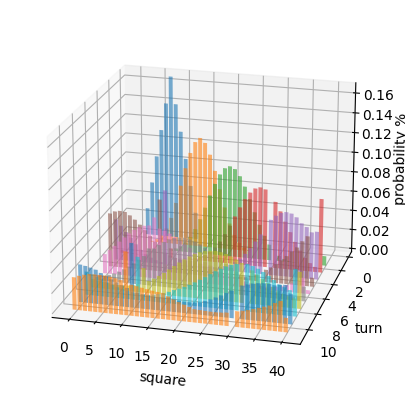

In [2]:
#
turns = 12

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(projection='3d')

ys = pi
for i in range(turns):
    xs = np.arange(len(squares))
    ys = ys@A
    ax.bar(xs,ys[0], zs=i, zdir='y', alpha=0.6)

ax.set_xlabel('square')
ax.set_ylabel('turn')
ax.invert_yaxis()
ax.set_zlabel('probability %')

ax.view_init(20, -75)
plt.show()

## 3.a Computing the stationary distribution


Compute the stationary distribution $\mu$ of the Markov Chain, by using either one of the following properties:
 - $\lim_{n\rightarrow \infty} A^n = \mu$
 - $\mu \cdot A = \mu$. In other word $\mu$ is the eigenvector associated with the eigenvalue $1$.
 
Both can be obtained with the linear algebra functions of numpy. 

Verify that you get something similar to this image (this will not be exactly the same as it was obtained from a more detailled model):

![monopoly_stationary.png](attachment:monopoly_stationary.png)


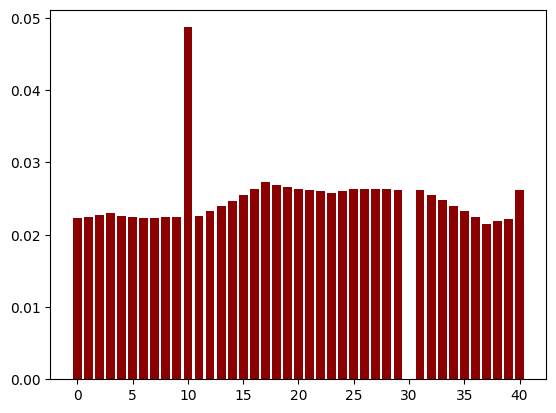

In [3]:
#np.linalg.matrix_power is one function you can use
#
my = LA.matrix_power(A,100)[0]

plt.bar(np.arange(len(my)),my,color='darkred')
plt.show()

Can you explain why some locations are more visited than others?

_your answer here_

## 3b. Convergence to the stationnary distribution

Use the successive powers of the matrix to determine the number of turns after which the chain converged to the stationary distribution (_e.g._ when the difference between the distribution of the rows of the matrix and the stationnary distribution is below 1%)



In [6]:
# Your code here
threshold = 0.01

conv_point = 0
x = A[0]
while np.linalg.norm(my - x) > threshold:
    x = LA.matrix_power(A,conv_point)[0]
    conv_point += 1

print("Convergence point:", conv_point)

Convergence point: 30


## 3c. Evaluating investments   

We provide in attachment a table with all the incomes associated to the various properties of the board. Let's see how we can use that information to understand how to evaluate the various real estate investments on the board.

For each square $k$ of the monopoly, we thus know the cost $c_{k}$ of the property, the price $h_k$ of an house and the rent $r_{k,h}$ with $h$ house. The total cost of a property with $h$ house is $c_{k,h}= c_k + h\cdot h_k$ 

1. Verify that the expected income per opponent turn on square $k$ is $i_{k,h} = \mu_k \cdot r_{k,h}$ and compute this value for all square and all number of houses. For instance a property where an opponent as 5% chance of landing with a rent of 100\\$ provides an expected income per turn of 5\\$.

2. Now an interesting quantity is the expected number of opponents turns before we are able to return on our investment with buying the property. For instance if the property mentionned in q.1 costed 50\\$, given that we expect to earn 5\\$ per turn with no house, our average waiting time before returning on our investment will be after $\frac{50}{5}=10$ opponent turns. Verify that the general formula for this value is:
$$
e_{k,h} = \frac{c_{k,h}} {i_{k,h}}
$$

3. compute $e_{k,h}$ for all square and all number of houses and check the most rentable properties, as a function of the number of houses.

4. (optional). Compute the expected number of turns to get a return of investment on a given color.


5. A classical recommendation for Monopoly is to buy orange properties, can you back up this claim?

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# read monopoly square data in Monopoly_square_data.csv
data = pd.read_excel('/content/drive/MyDrive/Monopoly_squares_data.xlsx')

i_k_h = np.zeros((40, 7), dtype=np.float64)

for i in range(40):
    for j in range(7):
      i_k_h[i][j] = my[i]*data.iat[i, j+2]


i_k_h = np.delete(i_k_h,1,1) # delete rent color set

e_k_h = np.zeros((40, 6), dtype=np.float64)

for k in range(40):
  for l in range(6):
    e_k_h[k][l] = (data.iat[k, 1]+l*data.iat[k,9])/i_k_h[k][l]

e_nan=np.array(e_k_h[~np.isnan(e_k_h).any(axis=1)])

print(e_nan)

# Compute i_k_h 

# Compute e_k_h

[[1332.51159807  488.58758596  236.89095077  103.63979096   72.17771156
    55.07714605]
 [ 653.43332171  239.59221796  116.16592386   50.82259169   35.39430493
    30.00953033]
 [ 746.2282357   223.86847071   99.49709809   41.45712421   33.58027061
    28.49235082]
 [ 743.97588295  223.19276488   99.19678439   41.3319935    33.47891473
    28.40635189]
 [ 667.40741654  189.09876802   97.88642109   40.04444499   31.6400553
    27.43786046]
 [ 621.33104618  213.02778726  100.5964551    43.39454926   38.34500171
    37.87160662]
 [ 584.79498984  200.50113937   94.68109359   40.84282469   36.09020509
    35.644647  ]
 [ 540.52775682  175.67152097   81.07916352   37.29641522   32.43166541
    29.72902662]
 [ 489.03104967  152.14299323   72.26792179   33.19483489   29.41431202
    27.22558826]
 [ 479.19667334  149.08340948   70.8146195    32.52728934   28.8227925
    26.6780838 ]
 [ 470.74134275  141.22240282   68.47146804   31.38275618   28.24448056
    26.36151519]
 [ 466.88815392  157.04

## 4. Improving the model

By using the article provided on the moodle (also reproduced [at this adress](http://www.math.yorku.ca/Who/Faculty/Steprans/Courses/2042/Monopoly/Stewart4.html)), design a more realistic transition matrix that would take into account double on the dice as well as the traditional getting out of jail. 

You will integrate the following ingredients:
- Double allow the player to do a second roll
- Player always try to get out of jail by throwing the dice up to three times
- (optional) Account for the cards in Chance and community chests that redirect the token to other cases (more details are given in the article)



In [ ]:
## Design the improved transition matrix here







Recompute the values of question 2 and 3a with this new matrix and comment on possible difference.

In [ ]:
## Compute powers of the matrix and the stationary distribution



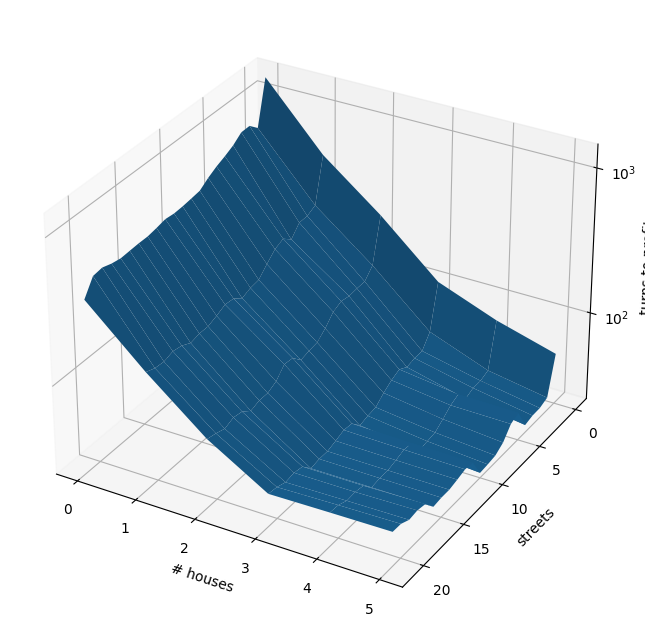

In [13]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker

streets = [
"Boulevard de Belleville",
"Rue Lecourbe",
"Rue de Vaugirard",
"Rue de Courcelles",
"Avenue de la République",
"Boulevard de la Villette",
"Avenue de Neuilly",
"Rue de Paradis",
"Avenue Mozart",
"Boulevard Saint-Michel",
"Place Pigalle",
"Avenue Matignon",
"Boulevard Malesherbes",
"Avenue Henri-Martin",
"Faubourg Saint-Honoré",
"Place de la Bourse",
"Rue La Fayette",
"Avenue de Breteuil",
"Avenue Foch",
"Boulevard des Capucines",
"Avenue des Champs-Élysées",
"Rue de la Paix"]

array_2d = np.array(e_nan)

x = np.arange(array_2d.shape[1])
y = np.arange(array_2d.shape[0])
X, Y = np.meshgrid(x, y)
Z = array_2d

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, np.log10(Z))

ax.invert_yaxis()


def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))


ax.set_xlabel('# houses')
ax.set_ylabel('streets')
ax.set_zlabel('turns to profit')


plt.show()


In [ ]:
print(A)

In [19]:
## Design the improved transition matrix here

TwoDices_2 = np.concatenate(([0],TwoDices,np.zeros(24-len(TwoDices), dtype=np.float64)), axis=0)
pasch = TwoDices_2

for i in range(2,13,2):
  pasch[i] = pasch[i]-1/36
  pasch = pasch+(np.roll(TwoDices_2,i)*1/36)

jail = np.zeros(40)
for i in range(2,13,2):
  jail[i+ivisite] = 1/36

a_2 = np.concatenate((pasch,np.zeros(40-len(pasch),dtype=np.float64)), axis=0)

A_2 = np.zeros((nsquares-1, nsquares-1), dtype=np.float64)

for i in range(len(A_2)):
  A_2[i] = np.roll(a_2,i)


A_2 = np.c_[ A_2, np.zeros(len(A_2)) ]
A_2 = np.vstack([A_2, np.concatenate((jail,[0]), axis=0)])
A_2 = np.c_[ A_2, np.zeros(len(A_2)) ]
A_2[-1][-1] = 5/6
A_2 = np.vstack([A_2, np.concatenate((jail,[0,0]), axis=0)])
A_2 = np.c_[ A_2, np.zeros(len(A_2)) ]
A_2[-1][-1] = 5/6
A_2 = np.vstack([A_2, np.concatenate((jail,[0,0,0]), axis=0)])

A_2[-1][ivisite] = 5/6

for i in range(40):
  A_2[i][-3] = A_2[i][iprison]
  A_2[i][iprison] = 0
A_2[iprison] = np.zeros(len(A_2),dtype=np.float64)



pi_2=np.zeros((1, len(A_2)))
pi_2[0,0] = 1

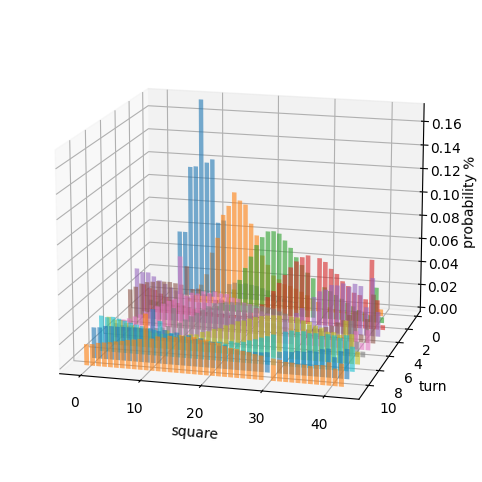

In [24]:
turns = 12

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

ys = pi_2
for i in range(turns):
    xs = np.arange(len(A_2))
    ys = ys@A_2
    ax.bar(xs,ys[0], zs=i, zdir='y', alpha=0.6)

ax.set_xlabel('square')
ax.set_ylabel('turn')
ax.invert_yaxis()
ax.set_zlabel('probability %')


ax.view_init(15, -75)

plt.show()


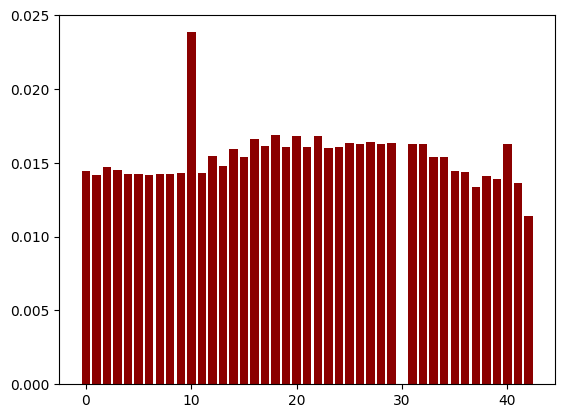

In [27]:

my_2 = LA.matrix_power(A_2,100)[0]


plt.bar(np.arange(len(my_2)),my_2,color="darkred")
plt.show()